In [1]:
import tensorflow as tf
import tensorflow.feature_column as fc 
import pandas as pd
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
URL_TRAIN = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
URL_VAL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

In [3]:
df_train = pd.read_csv(URL_TRAIN)
df_val = pd.read_csv(URL_VAL)
y_train = df_train.pop('survived')
y_val = df_val.pop('survived')

In [11]:
df_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
categorical_features = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
numeric_features = ['age', 'fare']

feature_columns = []
for feature_name in categorical_features:
    vocabulary = df_train[feature_name].unique()
    feature_columns.append(fc.categorical_column_with_vocabulary_list(feature_name, vocabulary))
  
for feature_name in numeric_features:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

In [5]:
def estimator_input_fn(df_data, df_label, epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(df_data), df_label))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(epochs)
        return ds
    return input_function

train_input_fn = estimator_input_fn(df_train, y_train)
val_input_fn = estimator_input_fn(df_val, y_val, epochs=1, shuffle=False)

In [6]:
ds = estimator_input_fn(df_train, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print('A batch of class:', feature_batch['class'].numpy())
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
A batch of class: [b'Third' b'First' b'Second' b'First' b'First' b'Third' b'Third' b'Second'
 b'Third' b'Second']
A batch of Labels: [0 1 0 1 1 1 0 1 0 0]


In [7]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(val_input_fn)

print(result)

W0405 19:55:45.410856 4490126784 estimator.py:1799] Using temporary folder as model directory: /var/folders/h6/hz0znrf9299dw0sn65qnms480000gn/T/tmp7onnjkrm
W0405 19:55:45.424113 4490126784 deprecation.py:323] From /Users/am/anaconda3/envs/tf2p0/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0405 19:55:46.010959 4490126784 deprecation.py:323] From /Users/am/anaconda3/envs/tf2p0/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:300: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0405 19:55:46.659795 4490126784 deprecation.py:506] From /Users/am/anaconda3

{'accuracy': 0.75, 'accuracy_baseline': 0.625, 'auc': 0.80027544, 'auc_precision_recall': 0.7406703, 'average_loss': 0.55785817, 'label/mean': 0.375, 'loss': 0.5480919, 'precision': 0.72, 'prediction/mean': 0.276218, 'recall': 0.54545456, 'global_step': 200}


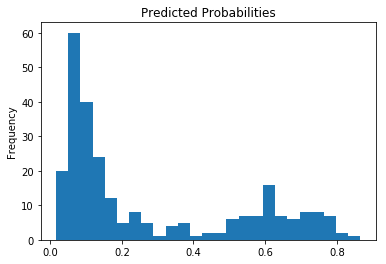

In [8]:
pred_dicts = list(linear_est.predict(val_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=25, title='Predicted Probabilities')

(0, 1.05)

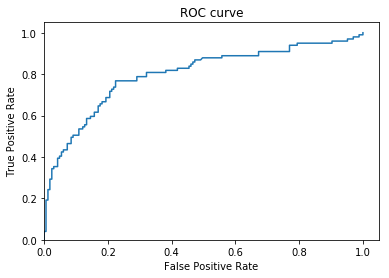

In [9]:
fpr, tpr, _ = roc_curve(y_val, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,)
plt.ylim(0,)